In [1]:
import hopsworks

project = hopsworks.login()

fs = project.get_feature_store()

C:\Users\hubak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/556181
Connected. Call `.close()` to terminate connection gracefully.


In [2]:
bitcoin_fg = fs.get_feature_group(
    name='bitcoin_analysis',
    version=1
)

In [3]:
training_data = bitcoin_fg.select_all()

In [4]:
version = 1 
feature_view_training = fs.get_or_create_feature_view(
    name='bitcoin_analysis_training_fv',
    version=version,
    query=training_data
)

In [5]:
X, _ = feature_view_training.training_data(
    description='Training data for the prediction system from the historically available data.'
)

Finished: Reading data from Hopsworks, using ArrowFlight (1.39s) 


In [6]:
import pandas as pd
pd.options.display.float_format = '{:.4f}'.format
sorted_X = X.sort_values(by='id')

In [7]:
sorted_X['date'] = pd.to_datetime(sorted_X['date'])

# Extracting date components
sorted_X['year'] = sorted_X['date'].dt.year
sorted_X['month'] = sorted_X['date'].dt.month
sorted_X['day'] = sorted_X['date'].dt.day
sorted_X['day_of_week'] = sorted_X['date'].dt.dayofweek

In [8]:
sorted_X.tail()

,date,open,high,low,close,volume,ma7,ma21,bollinger_upper,bollinger_lower,...,volatility,close_usd_index,close_oil,close_gold,hash_rate,id,year,month,day,day_of_week
2969,2024-05-23 00:00:00+00:00,69121.3047,70041.2734,66356.9531,67929.5625,41895680979,68415.3817,64687.7608,71051.6305,58323.8911,...,1892.8144,105.1100,76.8700,2335.0000,644799036.2919,3408,2024,5,23,3
175,2024-05-24 00:00:00+00:00,67928.1328,69220.2969,66622.6719,68526.1016,29197308153,68625.9855,64956.1544,71475.0772,58437.2316,...,1795.3230,104.7200,77.7200,2332.5000,671140034.7624,3409,2024,5,24,4
622,2024-05-25 00:00:00+00:00,68526.9219,69579.3203,68515.8203,69265.9453,15473071741,68958.1484,65212.0817,71972.9551,58451.2082,...,1639.9440,104.7200,77.7200,2332.5000,671140034.7624,3410,2024,5,25,5
933,2024-05-26 00:00:00+00:00,69264.2891,69506.2266,68183.8906,68518.0938,15628433737,69278.1094,65425.7465,72312.3047,58539.1882,...,1185.4881,104.7200,77.7200,2332.5000,671140034.7624,3411,2024,5,26,6
1741,2024-05-27 00:00:00+00:00,68512.1797,70597.8828,68232.5000,69394.5547,25870990717,68984.7321,65722.5372,72735.3869,58709.6875,...,722.7364,104.7200,77.7200,2332.5000,671140034.7624,3412,2024,5,27,0


In [9]:
final_X = sorted_X.drop(columns=['id', 'date'])

In [10]:
y = final_X.pop('close')

In [11]:
final_X.tail()

,open,high,low,volume,ma7,ma21,bollinger_upper,bollinger_lower,lag7,volatility,close_usd_index,close_oil,close_gold,hash_rate,year,month,day,day_of_week
2969,69121.3047,70041.2734,66356.9531,41895680979,68415.3817,64687.7608,71051.6305,58323.8911,65231.5820,1892.8144,105.1100,76.8700,2335.0000,644799036.2919,2024,5,23,3
175,67928.1328,69220.2969,66622.6719,29197308153,68625.9855,64956.1544,71475.0772,58437.2316,67051.8750,1795.3230,104.7200,77.7200,2332.5000,671140034.7624,2024,5,24,4
622,68526.9219,69579.3203,68515.8203,15473071741,68958.1484,65212.0817,71972.9551,58451.2082,66940.8047,1639.9440,104.7200,77.7200,2332.5000,671140034.7624,2024,5,25,5
933,69264.2891,69506.2266,68183.8906,15628433737,69278.1094,65425.7465,72312.3047,58539.1882,66278.3672,1185.4881,104.7200,77.7200,2332.5000,671140034.7624,2024,5,26,6
1741,68512.1797,70597.8828,68232.5000,25870990717,68984.7321,65722.5372,72735.3869,58709.6875,71448.1953,722.7364,104.7200,77.7200,2332.5000,671140034.7624,2024,5,27,0


In [12]:
X_train = final_X.iloc[:3000]
y_train = y.iloc[:3000]

X_test = final_X.iloc[3000:]
y_test = y.iloc[3000:]

XGBOOST MODEL

In [13]:
import xgboost as xgb

# Convert training data to DMatrix, which is a required data structure for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)

# Define the parameter grid
xgb_param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'n_estimators': [100, 200, 300]
}

# Create a parameter grid for tuning
param_combinations = []
for max_depth in xgb_param_grid['max_depth']:
    for learning_rate in xgb_param_grid['learning_rate']:
        for subsample in xgb_param_grid['subsample']:
            for colsample_bytree in xgb_param_grid['colsample_bytree']:
                    param_combinations.append({
                        'max_depth': max_depth,
                        'learning_rate': learning_rate,
                        'subsample': subsample,
                        'colsample_bytree': colsample_bytree,
                        'objective': 'reg:squarederror'
                        })

# Perform cross-validation
best_score = float("inf")
best_params = None

for params in param_combinations:
    cv_results = xgb.cv(dtrain=dtrain, params=params, nfold=5,
                        num_boost_round=200, early_stopping_rounds=10,
                        metrics="rmse", as_pandas=True, seed=42)
    
    mean_rmse = cv_results['test-rmse-mean'].min()
    if mean_rmse < best_score:
        best_score = mean_rmse
        best_params = params

In [14]:
xgb_model = xgb.train(dtrain=dtrain, params=best_params, num_boost_round=200)

In [16]:
dtest = xgb.DMatrix(X_test)
y_pred = xgb_model.predict(dtest)

In [17]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error

mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

rmse = root_mean_squared_error(y_test, y_pred)
print("RMSE:", rmse)

r2 = r2_score(y_test, y_pred)
print("R^2:", r2)

mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)

MSE: 3244829.548591743
RMSE: 1801.3410417219009
R^2: 0.9858528911899391
MAE: 951.3892786711165


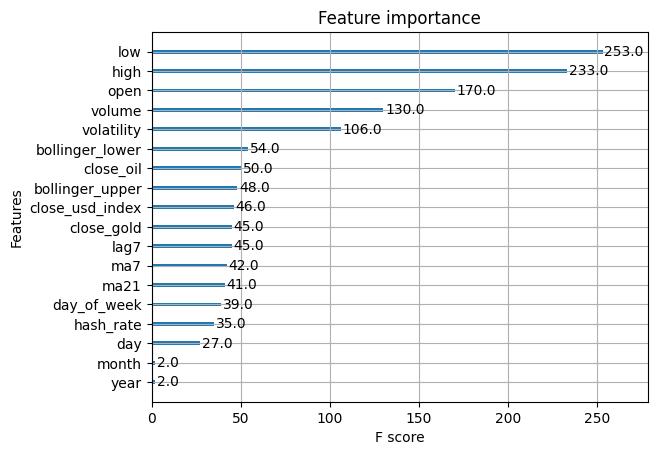

In [34]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
plot_importance(
    xgb_model, 
    max_num_features=20
)
plt.show()

In [19]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib

In [20]:
mr = project.get_model_registry()

input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

Connected. Call `.close()` to terminate connection gracefully.


In [37]:
import os
model_dir = "model"
if not os.path.isdir(model_dir):
    os.mkdir(model_dir)

joblib.dump(xgb_model, model_dir + "/bitcoin_price_prediction_model_xgboost.pkl")

['model/bitcoin_price_prediction_model_xgboost.pkl']

In [38]:
xgb_model_bitcoin = mr.python.create_model(
    name="bitcoin_price_prediction_model_xgboost",
    metrics={
        "MAE score": mae,
        "MSE score": mse,
        "RMSE score": rmse,
        "Rsquared score": r2
    },
    model_schema=model_schema,
    input_example=X_train.sample()
)
xgb_model_bitcoin.save(model_dir)

Uploading: 100.000%|██████████| 334874/334874 elapsed<00:01 remaining<00:00  3.64it/s]
Uploading: 100.000%|██████████| 235427/235427 elapsed<00:01 remaining<00:00  3.64it/s]
Uploading: 100.000%|██████████| 273/273 elapsed<00:00 remaining<00:00<00:09,  2.41s/it]
Uploading: 100.000%|██████████| 1524/1524 elapsed<00:01 remaining<00:00
Model export complete: 100%|██████████| 6/6 [00:12<00:00,  2.03s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/556181/models/bitcoin_price_prediction_model_xgboost/1


Model(name: 'bitcoin_price_prediction_model_xgboost', version: 1)

RANDOM FOREST REGRESSION MODEL

In [47]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
rf_grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                              param_grid=rf_param_grid,
                              cv=5,
                              n_jobs=-1,
                              verbose=2)

# Fit the grid search to the data
rf_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [50]:
rf_model = rf_grid_search.best_estimator_

y_pred_rf = rf_model.predict(X_test)

In [51]:
mse_rf = mean_squared_error(y_test, y_pred_rf)
print("MSE:", mse_rf)

rmse_rf = root_mean_squared_error(y_test, y_pred_rf)
print("RMSE:", rmse_rf)

r2_rf = r2_score(y_test, y_pred_rf)
print("R^2:", r2_rf)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
print("MAE:", mae_rf)

MSE: 1967354.3591779682
RMSE: 1402.624097603477
R^2: 0.9914225460011242
MAE: 767.7310283297936


In [52]:
import os
model_dir = "model"
if not os.path.isdir(model_dir):
    os.mkdir(model_dir)

joblib.dump(rf_model, model_dir + "/bitcoin_price_prediction_model_random_forest.pkl")

['model/bitcoin_price_prediction_model_random_forest.pkl']

In [53]:
rf_model_bitcoin = mr.python.create_model(
    name="bitcoin_price_prediction_model_random_forest",
    metrics={
        "MAE score": mae_rf,
        "MSE score": mse_rf,
        "RMSE score": rmse_rf,
        "Rsquared score": r2_rf
    },
    model_schema=model_schema,
    input_example=X_train.sample()
)
rf_model_bitcoin.save(model_dir)

Uploading: 100.000%|██████████| 840/840 elapsed<00:01 remaining<00:0000:01,  3.03it/s]
Uploading: 100.000%|██████████| 27275825/27275825 elapsed<00:05 remaining<00:0003it/s]
Uploading: 100.000%|██████████| 235427/235427 elapsed<00:01 remaining<00:00  3.03it/s]
Uploading: 100.000%|██████████| 274/274 elapsed<00:01 remaining<00:00<00:21,  5.35s/it]
Uploading: 100.000%|██████████| 1524/1524 elapsed<00:01 remaining<00:00
Model export complete: 100%|██████████| 6/6 [00:18<00:00,  3.01s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/556181/models/bitcoin_price_prediction_model_random_forest/1


Model(name: 'bitcoin_price_prediction_model_random_forest', version: 1)